In [2]:
library(magrittr)
library(caret)
library(zeallot)
library(Matching)
library(tidyverse)
source("R/simulation_scenarios.R")
source("R/hte_caret.R")
source("R/hte_cv.R")
source("R/eval_hte_cv.R")
plotsize = function (x,y) options(repr.plot.width=x, repr.plot.height=y)

In [3]:
model_specs = list(
    gbm = list(
        tune_grid = expand.grid(
            n.trees = seq(1,501,40), 
            interaction.depth=3, 
            shrinkage = 0.1, 
            n.minobsinnode=3),
        extra_args = list(
            verbose=F, 
            bag.fraction=0.5)),
    glmnet = list(
        tune_grid = expand.grid(
            alpha=c(0,0.5,1),
            lambda=exp(seq(-5,2,0.4))),
        extra_args = list()))

metrics = list(
    mse = bundle_mse,
    wmse = bundle_wmse,
    r_objective = bundle_r_objective,
    match_mse = bundle_match_mse,
    trans_mse = bundle_trans_mse,
    match_mdc = bundle_match_mdc,
    trans_mdc = bundle_trans_mdc,
    ip_value = bundle_ip_value,
    dml_value = bundle_dml_value,
    gain = bundle_gain,
#     c_benefit = bundle_c_benefit,
    qini = bundle_qini,
    random = bundle_random)

DGPs = powers_DGPs()
randomized = c(rep(T,8), rep(F,8))
c(n_train, n_val, n_test) %<-% list(1000, 1000, 1000)

In [23]:
SCENARIO = 5

In [24]:
data = create_data(DGPs[[SCENARIO]], n_train + n_val + n_test)
itrain = 1:n_train
ival = itrain + n_train
itest = ival + n_val

In [25]:
estimates = estimate_val_test(data, itrain, model_specs)

In [26]:
val_bundle = learn_validation_auxiliaries(data, ival, model_specs, randomized=randomized[SCENARIO])

In [27]:
val_metrics = estimate_val_metrics(estimates, val_bundle, metrics, ival)

In [28]:
test_metrics = calc_test_metrics(data, estimates, itest)

----

----

----

Warning message:
: Removed 40 rows containing missing values (geom_point).

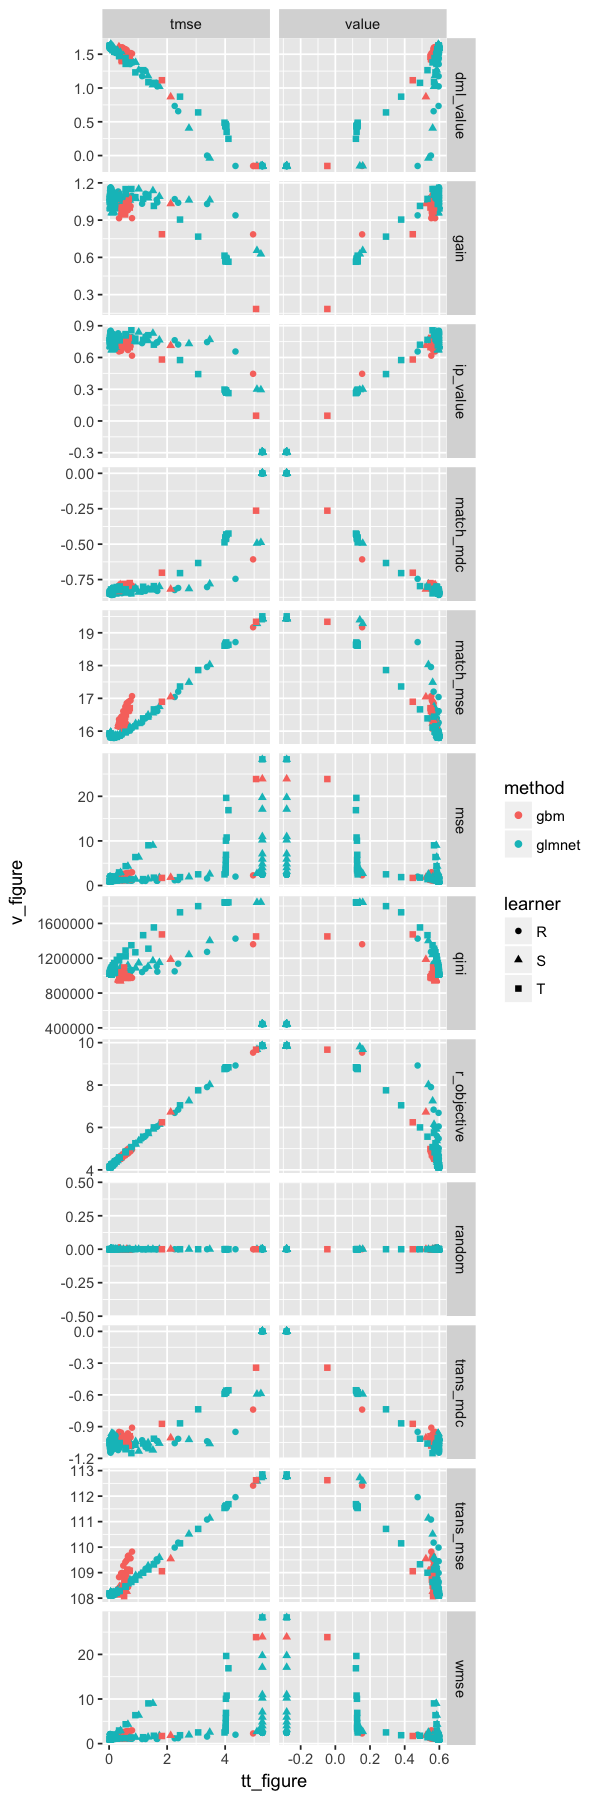

In [29]:
plotsize(5,15)

ttm = test_metrics %>% gather(tt_metric, tt_figure, -model)
vm = val_metrics %>% gather(v_metric, v_figure, -model)

inner_join(ttm, vm, by="model") %>%
    separate(model, c("learner", "model"), sep="\\$") %>%
    separate(model, c("method", "params"), sep="@") %>%
ggplot(aes(x=tt_figure, y=v_figure, color=method, shape=learner)) +
geom_point() +
facet_grid(v_metric~tt_metric, scales="free")